## Initialization

In [2]:
import unet, imageGeneration

## Define image parameters function

In [ ]:
def image_parameters_function(lower_limit_SNR, higher_limit_SNR, image_size = 256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    particle_number = randint(20, 30)
    particle_radius_list = uniform(0.5, 2, particle_number)
    (particle_center_x_list, particle_center_y_list) = imageGeneration.get_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.05, 0.13, 1), ])

    image_parameters = imageGeneration.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.3, .5),
        signal_to_noise_ratio=lambda: uniform(lower_limit_SNR, higher_limit_SNR),
        gradient_intensity=lambda: uniform(0, 0),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters

## Fit using generator

In [ ]:
import time
t = time.time()
from keras.callbacks import ModelCheckpoint

model = unet.create_unet("unet_particle.hdf5")

lower_SNR = [20, 18, 16, 14, 12, 12, 12, 12, 12]
higher_SNR = [30, 28, 26, 24, 22, 24, 26, 28, 30]

for i in range(9):
    print("lower SNR is " + str(lower_SNR[i]) + "; higher SNR is " + str(higher_SNR[i]))
    generator = imageGeneration.create_data_generator(get_image_parameters = lambda: image_parameters_function(lower_SNR[i], higher_SNR[i]),
                                          epoch_batch_size = 1000,
                                          batch_size = 32,
                                          len = 100)
    
    model_checkpoint = ModelCheckpoint('unet_particle.hdf5', monitor='loss',verbose=1, save_best_only=True)


    model.fit_generator(generator, epochs = 50, callbacks = [model_checkpoint])
    time_taken = time.time() - t
    print("Time taken for training: " + str(time_taken) + " s.")
    

## Loads network, predicts movie, saves batch and then loads it.

In [ ]:
import numpy as np
from nd2reader import ND2Reader

number_of_frames = 100

batch_images = np.zeros((number_of_frames,512,512,1))
with ND2Reader('20190313_400um_stch_nocholEV17_Q40_TIRF_002.nd2') as images:
    for i in range(number_of_frames):
        batch_images[i,:,:,0] = np.asarray(images[i])/255

model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")
batch_predictions = model.predict(batch_images)

batch = (batch_images, None, batch_predictions)
imageGeneration.save_batch(batch, image_path = 'data/videos/video2/images', prediction_path = 'data/videos/video2/predictions')

batch = imageGeneration.load_batch(number_of_frames, image_path = 'data/videos/video2/images', prediction_path = 'data/videos/video2/predictions')
(batch_images, batch_labels, batch_predictions) = batch

## Visualises batch and saves the generated images

In [ ]:
from matplotlib import pyplot as plt
number_of_images_to_show = 50
for j in range(number_of_images_to_show):
    cutoff_value = 0.9
    imageGeneration.visualise_batch(batch, apply_cutoff = True, apply_sigmoid = True, index_of_image_to_show = j, cutoff_value = cutoff_value)
    fig = plt.gcf()
    fig.savefig('video/prediction/test' + str(j) +'.png', dpi = 500)
    #Show the last image
    if(j!=number_of_images_to_show-1):
        plt.clf()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

lower_limit_SNR = 37
higher_limit_SNR = 37
batch_size = 10
batch = imageGeneration.get_batch(lambda: image_parameters_function(lower_limit_SNR, higher_limit_SNR), batch_size = batch_size)
(batch_images, batch_labels, batch_predictions) = batch

model = unet.create_unet(pretrained_weights = 'unet_particle.hdf5')
batch_predictions = model.predict(batch_images)
print(batch_labels.shape)

batch_new = (batch_images, batch_labels, batch_predictions)

example_image = batch_images[0,:,:,0]
first_feature_first_label = batch_labels[0,:,:,0]
first_feature_first_prediction = batch_predictions[0,:,:,0]
cv2.imwrite("Bild1.png", first_feature_first_prediction*255)
cv2.imwrite("Bild2.png", first_feature_first_label*255)


print(np.mean(example_image) ** (1/2) / np.std(example_image))


imageGeneration.visualise_batch(batch_new, apply_cutoff = True, apply_sigmoid = True, use_predictions = True, cutoff_value = 0.5)
plt.show()
imageGeneration.visualise_batch(batch_new, apply_cutoff = True, apply_sigmoid = False, use_predictions = False, cutoff_value = 0.5)


Time taken for batch generation of size 100: 1.239689588546753 s.
Mean is 0.4002, STD is 0.0173, SNR is 36.4860


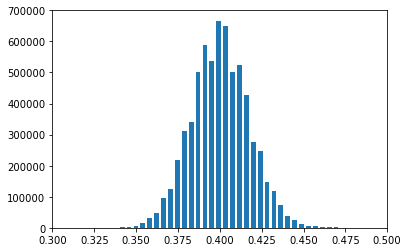

Mean is 0.4070, STD is 0.0171, SNR is 37.2701


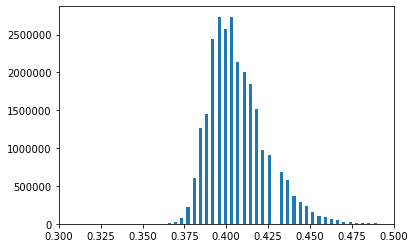

26214400


In [62]:
import numpy as np
from nd2reader import ND2Reader
from matplotlib import pyplot as plt
import cv2

def image_parameters_function(lower_limit_SNR, higher_limit_SNR, image_size = 256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    particle_number = randint(20, 30)
    particle_radius_list = uniform(0.5, 2, particle_number)
    (particle_center_x_list, particle_center_y_list) = imageGeneration.get_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.05, 0.13, 1), ])

    image_parameters = imageGeneration.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.4, .4),
        signal_to_noise_ratio=lambda: uniform(lower_limit_SNR, higher_limit_SNR),
        gradient_intensity=lambda: uniform(0, 0),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters

number_of_frames = 100

batch_images = np.zeros((number_of_frames,512,512,1))
with ND2Reader('20190313_400um_stch_nocholEV17_Q40_TIRF_002.nd2') as images:
    for i in range(number_of_frames):
        batch_images[i,:,:,0] = np.asarray(images[i])/255

(batch_generated_images, temp, temp) = imageGeneration.get_batch(lambda: image_parameters_function(37, 37), batch_size = number_of_frames)

test_generated_image = batch_generated_images[0, :, :, 0]
test_video_images = batch_images[0, :, :, 0]

# plt.imshow(test_generated_image)
# plt.colorbar()
# plt.show()
print("Mean is %.4f, STD is %.4f, SNR is %.4f" % (np.mean(batch_generated_images), np.std(batch_generated_images),
                                                 np.sqrt(np.mean(batch_generated_images))/np.std(batch_generated_images)))

hist, bins = np.histogram(batch_generated_images, bins = 70)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlim((0.3, 0.5))

plt.show()


# plt.imshow(test_video_images)
# plt.colorbar()
# plt.show()
print("Mean is %.4f, STD is %.4f, SNR is %.4f" % (np.mean(batch_images), np.std(batch_images),
                                                 np.sqrt(np.mean(batch_images))/np.std(batch_images)))

hist, bins = np.histogram(batch_images, bins = 100)
width = 0.5 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlim((0.3, 0.5))
plt.show()
print(batch_images.size)

        